<br>

## Imports

In [1]:
import time
import pickle
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve, auc, classification_report

<br>

Mount drive

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<br>

## Define constants

In [6]:
TEST_SIZE = .2
EVAL_SIZE = .1
RANDOM_SEED = 30
WHICH_TARGET = 'Level_1'

<br>

## Define classes

In [7]:
class seqembData(Dataset):
    def __init__(self, inputs, labels):
        for input in inputs:
            assert input.shape[0] == len(labels)
        
        self.n = len(labels)
        self.labels = torch.as_tensor(labels)
        self.inputs = [torch.as_tensor(input).float() for input in inputs]

    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        return [input[idx] for input in self.inputs], self.labels[idx]

In [8]:
class ecnumClassifier(nn.Module):
    def __init__(self, input_sizes, num_classes, hidden_size = 256, linear_sizes = [64, 64], drop_prob = .2):
        super().__init__()

        # Input processing layers
        proc_layers = []
        for size in input_sizes:
            proc_layer = nn.Sequential(
                nn.Dropout(p = drop_prob),
                nn.Linear(size, hidden_size),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_size)
            )
            proc_layers.append(proc_layer)
        self.proc_layers = nn.ModuleList(proc_layers)

        # Linear layers
        input_size = hidden_size * len(input_sizes)
        linear_layers = []
        for output_size in linear_sizes:
            linear_layers.append(nn.Dropout(p = drop_prob))
            linear_layers.append(nn.Linear(input_size, output_size))
            linear_layers.append(nn.ReLU())
            linear_layers.append(nn.BatchNorm1d(output_size))
            input_size = output_size
        self.linear_layers = nn.Sequential(*linear_layers)

        # Output layer        
        self.output_layer = nn.Linear(input_size, num_classes)
    
    def forward(self, x_list):
        # Process inputs by independent processign layers
        y_list = []
        for i, proc_layer in enumerate(self.proc_layers):
            y_list.append(proc_layer(x_list[i]))

        # Concat together            
        y = torch.cat(y_list, dim = 1)

        # Pass through linear layers
        z = self.linear_layers(y)

        # Get output
        o = self.output_layer(z)

        return o

<br>


Aux. functions

In [9]:
def get_preds(logits):
    proba = torch.log_softmax(logits, dim = 1)
    _, preds = torch.max(proba, dim = 1)
    return proba, preds

def calc_acc(preds, targets):
    return torch.sum(preds == targets) / len(targets)

In [10]:
class ecnumTrainer():
    def __init__(self, model, train_data, eval_data = None, batch_size = 32, learning_rate = 1e-4, decay = 1e-5, device = 'cpu'):

        # Set device
        self.device = device

        # Set model
        self.model = model
        
        # Set train data loader
        self.train_loader = DataLoader(
            train_data,
            batch_size = batch_size,
            shuffle = True
        )

        # Set optimizer
        self.optimizer = Adam(
            self.model.parameters(),
            lr = learning_rate,
            weight_decay = decay
        )

        # Set eval data loader
        if eval_data is not None:
            self.eval_loader = DataLoader(
                eval_data, 
                batch_size=len(eval_data),
                shuffle = False
            )
        else:
            self.eval_loader = None

        # Set loss function
        self.loss_func = nn.CrossEntropyLoss() 

    def validate(self):
        self.model.eval()
        with torch.no_grad():
            inputs, targets = next(iter(self.eval_loader))
            inputs = [input.to(self.device) for input in inputs]
            logits = self.model(inputs)

            # Calc error
            error = self.loss_func(logits, targets)
            error = error.item()

        return logits, targets, error

    def train(self, num_epochs = 20, verbosity = 10):

        # Train track container
        train_track = {'error' : [], 'accuracy' : []}
        if self.eval_loader is not None:
            eval_track = {'error' : [], 'accuracy' : []}
            eval_preds = {}
        else:
            eval_track = None
            eval_preds = None

        # Set device
        self.model.to(self.device)
        
        # Training
        n = len(self.train_loader)
        start = time.time()
        for epoch in range(num_epochs):
            self.model.train()
            train_error = 0.    
            train_acc = 0.        
            for i, (inputs, targets) in enumerate(self.train_loader):
                inputs = [input.to(self.device) for input in inputs]
                logits = self.model(inputs)

                # Calc error and do training step
                error = self.loss_func(logits, targets)
                self.optimizer.zero_grad()
                error.backward()
                self.optimizer.step()
                error = error.item()

                # Get predictions
                _, preds = get_preds(logits)

                # Calculate accuracy
                acc = calc_acc(preds, targets)
                acc = acc.item()

                # Report
                if verbosity > 0:
                    if (i + 1) % verbosity == 0:
                        print('Epoch: {}/{}\t Batch: {}/{}\t Error: {:1.3f}\t Accuracy: {:1.2f}'.format(epoch + 1, num_epochs, i + 1, n, error, acc))

                # Increment training error and accuracy              
                train_error += error                
                train_acc += acc

            # Average training error
            train_error /= n      
            train_track['error'].append(train_error)

            # Average training accuracy
            train_acc /= n
            train_track['accuracy'].append(train_acc)

            # Validation
            if self.eval_loader is not None:
                logits, targets, error = self.validate()

                # Get predictions
                _, preds = get_preds(logits)

                # Assess accuracy
                acc = calc_acc(preds, targets)
                acc = acc.item()

                # Add to eval track
                eval_track['error'].append(error)
                eval_track['accuracy'].append(acc)

                # Add to eval preds
                eval_preds['epoch_{}'.format(epoch + 1)] = {
                    'preds' : preds.cpu().numpy(),
                    'targets' : targets.cpu().numpy()
                }

                print('\n')
                print('\t Epoch: {}'.format(epoch + 1))
                print('\t Validation loss: {:1.2f}'.format(error))
                print('\t Validation accuracy: {:1.2f}'.format(acc))
                print('\t Elapsed time: {:1.1f}'.format(time.time()-start))
                print('\n')

        return train_track, eval_track, eval_preds


In [11]:
class ecnumTester():
    def __init__(self, model, test_data, device = 'cpu'):

        # Set device
        self.device = device

        # Set model
        self.model = model
        
        # Set test data loader
        self.test_loader = DataLoader(
            test_data, 
            batch_size=len(test_data),
            shuffle = False
        )

        # Set loss function
        self.loss_func = nn.CrossEntropyLoss() 

    def test(self):
        self.model.eval()
        with torch.no_grad():
            inputs, targets = next(iter(self.test_loader))
            inputs = [input.to(self.device) for input in inputs]
            logits = self.model(inputs)

            # Calc error
            error = self.loss_func(logits, targets)
            error = error.item()

            # Get predictions
            proba, preds = get_preds(logits)

            # Assess accuracy
            acc = calc_acc(preds, targets)
            acc = acc.item()

        # Store targets
        self.targets = targets.cpu().numpy()
        self.proba = proba.cpu().numpy()
        self.preds = preds.cpu().numpy()
 
        return error, acc

    def get_report(self):            
        labels = list(range(self.proba.shape[1]))
        return classification_report(self.targets, self.preds, labels=labels)

    def get_confmat(self):
        labels = list(range(self.proba.shape[1]))
        conf_mat = confusion_matrix(
            self.targets, 
            self.preds,
            labels = labels
        )
        return conf_mat

    def get_roc(self):
        fpr = {}
        tpr = {}
        auroc = {}
        for i in range(self.proba.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(self.targets, self.proba[:,i], pos_label = i)
            auroc[i] = auc(fpr[i], tpr[i])
        return fpr, tpr, auroc


In [12]:
def plot_confmat(cm, title = None, file_name = None, include_values = True):
    fig, ax = plt.subplots(figsize=(10, 7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax = ax, include_values = include_values)
    
    if title is not None:
        disp.ax_.set_title(title)

    fig.tight_layout()
    if file_name is None:
        plt.show()
    else:
        plt.savefig(file_name, dpi = 100)

In [13]:
def plot_tracks(errors, accuracies, eval_errors = None, eval_accuracies = None, title = None, file_name = None):
    # Prepare x-values
    x = np.arange(len(errors)) + 1.
    
    # Prepare plot
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epochs [#]')
    ax1.minorticks_on()
    ax1.grid()
    
    # Plot errors
    color = 'maroon'
    ax1.plot(x, errors, color=color)    
    ax1.set_ylabel('Cross-Entropy Loss', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    # Plot evaluation errors
    if eval_errors:
        ax1.plot(x, eval_errors, color=color, linestyle='dashed')    

    # Plot performance
    color = 'steelblue'
    ax2 = ax1.twinx()
    ax2.plot(x, accuracies, color=color)
    ax2.set_ylabel('Accuracy', color=color)
    ax2.tick_params(axis='y', labelcolor=color)    
    # Plot evaluation accuracies
    if eval_accuracies :
        ax2.plot(x, eval_accuracies, color=color, linestyle='dashed')


    # Add title
    if title is not None:
        plt.suptitle(title)

    # Plot
    fig.tight_layout() 
    if file_name is None:
        plt.show()
    else:
        plt.savefig(file_name, dpi = 100)


In [14]:
def plot_rocs(fpr, tpr, auroc, title = None, file_name = None, show_legend = True):
    plt.figure()
    lw = 1
    classes = fpr.keys()
    for c in classes:                        
        plt.plot(
            fpr[c], tpr[c], 
            # color='darkorange',
            lw=lw, 
            label='Class: {}; AUROC = {:1.2f}'.format(c, auroc[c])
        )
        plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
    plt.grid()

    if show_legend:
        plt.legend(loc="lower right")    

    if title is not None:
        plt.title(title)

    if file_name is None:
        plt.show()
    else:
        plt.savefig(file_name, dpi = 100)

<br>

## Load data and create datasets (train, eval, test)

In [15]:
path = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/embeddings/esm_embeddings.p'
with open(path, 'rb') as f:
    esm_embedding_output = pickle.load(f)

In [16]:
path = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/embeddings/ProtAlbert_embeddings.p'
with open(path, 'rb') as f:
    protalbert_embedding_output = pickle.load(f)

In [17]:
path = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/embeddings/TAPE_embeddings.p'
with open(path, 'rb') as f:
    tape_embedding_output = pickle.load(f)

<br>

Assert data integrity

In [18]:
assert esm_embedding_output['seq_data'].shape == protalbert_embedding_output['seq_data'].shape

In [19]:
assert tape_embedding_output['seq_data'].shape == protalbert_embedding_output['seq_data'].shape

<br>

Select labels and inputs

In [20]:
labels = esm_embedding_output['seq_data'][WHICH_TARGET].values
inputs = [
    esm_embedding_output['seq_embeddings'],         # Embeddings from esm
    protalbert_embedding_output['seq_embeddings'],  # Embeddings from protAlbert
    tape_embedding_output['seq_embeddings']         # Embeddings from TAPE
]

<br>

Sanitize against nans

In [21]:
nonan_idx = np.where(~np.isnan(labels))[0]
labels = labels[nonan_idx]
inputs = [input[nonan_idx] for input in inputs]

<br>

Encode labels

In [22]:
ec_encoder = LabelEncoder()
labels = ec_encoder.fit_transform(np.array(labels))

<br>

Train test split

In [23]:
train_idx, test_idx = train_test_split(
    range(len(labels)), 
    test_size=TEST_SIZE, 
    random_state=RANDOM_SEED
)

train_idx, eval_idx = train_test_split(
    train_idx, 
    test_size=EVAL_SIZE,
    random_state = RANDOM_SEED
)

<br>

Create datasets

In [24]:
# Train data
train_labels = labels[train_idx]
train_inputs = [input[train_idx] for input in inputs]
train_dataset = seqembData(train_inputs, train_labels)

# Eval data
eval_labels = labels[eval_idx]
eval_inputs = [input[eval_idx] for input in inputs]
eval_dataset = seqembData(eval_inputs, eval_labels)

# Test data
test_labels = labels[test_idx]
test_inputs = [input[test_idx] for input in inputs]
test_dataset = seqembData(test_inputs, test_labels)

<br>

## Train the model

<br>

Init model

In [25]:
input_sizes = [input.shape[1] for input in train_inputs]
num_classes = len(ec_encoder.classes_)
model = ecnumClassifier(
    input_sizes = input_sizes, 
    num_classes = num_classes,
    hidden_size = 256,
    linear_sizes = [512, 512, 64],
    drop_prob = .4
)

In [26]:
model = model.float()

<br>

Select device

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

<br>

Init trainer

In [28]:
trainer = ecnumTrainer(
    model,
    train_dataset,
    eval_dataset,
    batch_size = 32,
    learning_rate = 1e-4,
    device = device,
)

In [29]:
train_track, eval_track, eval_preds = trainer.train(num_epochs = 50, verbosity = 25)

Epoch: 1/50	 Batch: 25/375	 Error: 2.190	 Accuracy: 0.12
Epoch: 1/50	 Batch: 50/375	 Error: 1.907	 Accuracy: 0.19
Epoch: 1/50	 Batch: 75/375	 Error: 1.976	 Accuracy: 0.22
Epoch: 1/50	 Batch: 100/375	 Error: 1.922	 Accuracy: 0.22
Epoch: 1/50	 Batch: 125/375	 Error: 1.893	 Accuracy: 0.31
Epoch: 1/50	 Batch: 150/375	 Error: 2.046	 Accuracy: 0.19
Epoch: 1/50	 Batch: 175/375	 Error: 1.919	 Accuracy: 0.31
Epoch: 1/50	 Batch: 200/375	 Error: 1.945	 Accuracy: 0.28
Epoch: 1/50	 Batch: 225/375	 Error: 1.862	 Accuracy: 0.34
Epoch: 1/50	 Batch: 250/375	 Error: 1.713	 Accuracy: 0.38
Epoch: 1/50	 Batch: 275/375	 Error: 2.025	 Accuracy: 0.19
Epoch: 1/50	 Batch: 300/375	 Error: 1.916	 Accuracy: 0.22
Epoch: 1/50	 Batch: 325/375	 Error: 1.466	 Accuracy: 0.56
Epoch: 1/50	 Batch: 350/375	 Error: 1.777	 Accuracy: 0.34
Epoch: 1/50	 Batch: 375/375	 Error: 1.728	 Accuracy: 0.30


	 Epoch: 1
	 Validation loss: 1.76
	 Validation accuracy: 0.44
	 Elapsed time: 21.7


Epoch: 2/50	 Batch: 25/375	 Error: 1.648	 Acc

In [30]:
fname = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/results/eval_preds_{}.p'.format(WHICH_TARGET)
with open(fname, 'wb') as f:
    pickle.dump(eval_preds, f)

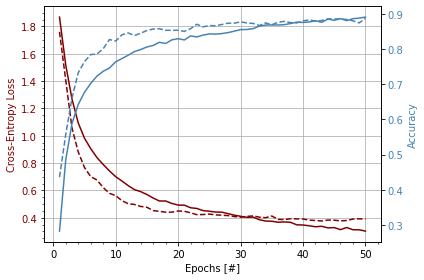

In [31]:
plot_tracks(
    train_track['error'],
    train_track['accuracy'],
    eval_errors = eval_track['error'],
    eval_accuracies = eval_track['accuracy'],
    file_name = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/results/tracks_{}.png'.format(WHICH_TARGET)
)

In [32]:
tester = ecnumTester(trainer.model, test_dataset)
err, acc = tester.test()
print('Test accuracy: {:1.2f}'.format(acc))

Test accuracy: 0.87


In [33]:
report = tester.get_report()
print(report)

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       575
           1       0.87      0.89      0.88      1071
           2       0.86      0.89      0.88      1064
           3       0.82      0.73      0.77       278
           4       0.90      0.76      0.82       169
           5       0.94      0.82      0.88       146
           6       0.62      0.55      0.58        29

    accuracy                           0.87      3332
   macro avg       0.84      0.80      0.82      3332
weighted avg       0.87      0.87      0.87      3332



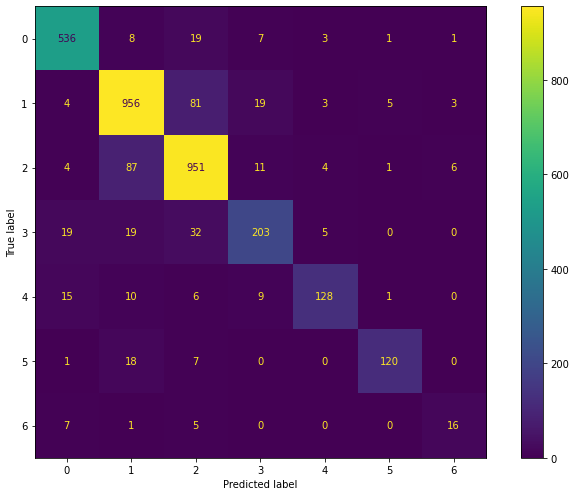

In [34]:
cm = tester.get_confmat()
plot_confmat(
    cm, 
    file_name = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/results/confmat_{}.png'.format(WHICH_TARGET)
)

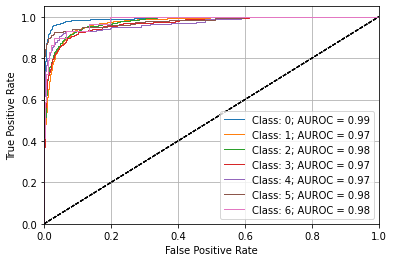

In [35]:
fpr, tpr, auroc = tester.get_roc()
plot_rocs(
    fpr, 
    tpr, 
    auroc, 
    file_name = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/results/rocs_{}.png'.format(WHICH_TARGET)
)

---